<a href="https://colab.research.google.com/github/Jmmostafa/VaRBacktestingEngine/blob/main/02_VaR_Model_Implementations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
# Installing Packages
!pip install arch scienceplots --quiet

# Data Preparation

In [46]:
# Quickly download the data
symbols = ['^GSPC', 'GC=F', '^TNX','EURUSD=X']
names = ['EURUSD', 'GOLD', 'GSPC', '10Y']

def calc_returns(symbols, names):
  import yfinance as yf
  import pandas as pd
  import numpy as np

  df = yf.download(symbols, start = '2020-01-01', auto_adjust= True)['Close'].dropna()
  df.columns = names
  df['10Y'] = df['10Y']/100
  df_returns = np.log(df/df.shift(1)).dropna()
  return df_returns

df_returns = calc_returns(symbols, names)
df_returns.head()

[*********************100%***********************]  4 of 4 completed


,EURUSD,GOLD,GSPC,10Y
Date,,,,
2020-01-03,-0.004411,0.016072,-0.007085,-0.051237
2020-01-06,-0.000849,0.010914,0.003527,0.012782
2020-01-07,0.003223,0.003569,-0.002807,0.008796
2020-01-08,-0.003870,-0.009204,0.004890,0.025400
2020-01-09,-0.003730,-0.003667,0.006633,-0.008574


# VaR Calculations

## Historical Simulated VaR

In [47]:
def historical_var_es(df_returns, confidence_level):
  import numpy as np
  import pandas as pd

  # Sort the returns in ascending order
  sorted_returns = np.sort(df_returns)

  # Calculate VaR
  var_idx = int(np.floor((1 - confidence_level) * len(sorted_returns)))
  VaR = sorted_returns[var_idx]

  # Calculate ES
  losses_beyond_var = sorted_returns[sorted_returns <= VaR]
  ES = np.mean(losses_beyond_var)

  return VaR, ES


# Calculating VaR and ES for each asset for different confidence levels
confidence_levels = np.arange(0.90, 1.00, 0.01)
results = []

for confidence in confidence_levels:
  for asset in df_returns.columns:
    var, es = historical_var_es(df_returns[asset].values, confidence_level= confidence)
    results.append({
      'Asset': asset,
      'Confidence Level': f"{confidence*100:.0f}%",
      'VaR': var,
      'ES': es
    })

df_hs_results = pd.DataFrame(results)
# df_hs_results.set_index(['Asset'], inplace= True)
df_hs_results.head()

,Asset,Confidence Level,VaR,ES
0,EURUSD,90%,-0.005649,-0.008470
1,GOLD,90%,-0.011923,-0.019904
2,GSPC,90%,-0.012396,-0.023819
3,10Y,90%,-0.029296,-0.058163
4,EURUSD,91%,-0.005978,-0.008766


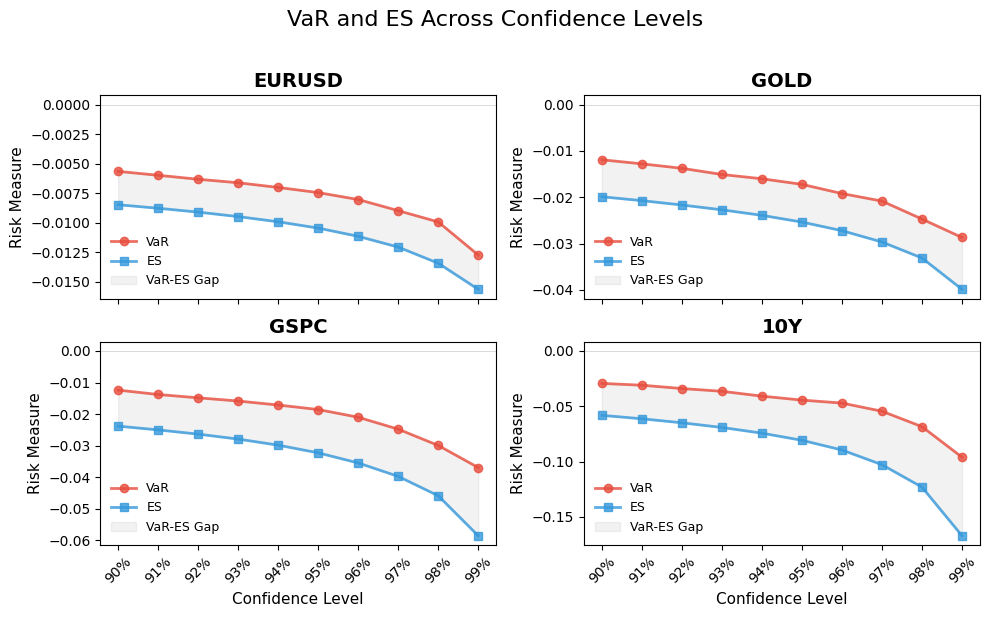

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get unique assets
assets = df_hs_results['Asset'].unique()
n_assets = len(assets)

# If you have more than 4 assets, take only the first 4
if n_assets > 4:
    assets = assets[:4]
    n_assets = 4

# Create 2x2 subplots with shared x-axis
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
axes = axes.flatten()

# Color palette for better visualization
colors = ['#E74C3C', '#3498DB']  # Red for VaR, Blue for ES

for idx, asset in enumerate(assets):
    ax = axes[idx]

    # Filter data for this asset and sort by confidence level
    asset_data = df_hs_results[df_hs_results['Asset'] == asset].copy()

    # Convert confidence level to numeric for proper sorting and plotting
    asset_data['Confidence_Numeric'] = asset_data['Confidence Level'].str.rstrip('%').astype(float)
    asset_data = asset_data.sort_values('Confidence_Numeric')

    # Get x-axis values
    conf_levels = asset_data['Confidence_Numeric'].values
    conf_labels = asset_data['Confidence Level'].values

    # Plot VaR and ES
    ax.plot(conf_levels, asset_data['VaR'],
            marker='o', markersize=6, label='VaR',
            linewidth=2, color=colors[0], alpha=0.8)
    ax.plot(conf_levels, asset_data['ES'],
            marker='s', markersize=6, label='ES',
            linewidth=2, color=colors[1], alpha=0.8)

    # Fill between lines (VaR-ES gap)
    ax.fill_between(conf_levels,
                    asset_data['VaR'],
                    asset_data['ES'],
                    color='gray', alpha=0.1,
                    label='VaR-ES Gap')

    # Customize each subplot
    ax.set_title(f'{asset}', fontsize=14, fontweight='bold')
    # Only set xlabel for bottom row to avoid redundancy with shared x-axis
    if idx >= n_assets - 2 or n_assets <= 2: # For 2x2 grid, idx 2 and 3 are bottom row
        ax.set_xlabel('Confidence Level', fontsize=11)
    else:
        ax.set_xlabel('') # Clear xlabel for top row
    ax.set_ylabel('Risk Measure', fontsize=11)
    ax.set_xticks(conf_levels)
    ax.set_xticklabels(conf_labels, rotation=45 if len(conf_levels) > 5 else 0, fontsize=10)

    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.2, linewidth=0.5)

    # Add grid (if desired - set to False if you prefer no grid)
    ax.grid(False)

    # Add legend to each subplot
    ax.legend(fontsize=9, loc='best', frameon = False)

# Remove empty subplots if we have less than 4 assets
for idx in range(n_assets, 4):
    axes[idx].set_visible(False)

# Add overall title
plt.suptitle('VaR and ES Across Confidence Levels', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

## Filtered Historical Simulated VaR

### EWMA VaR (RiskMetrics)

In [49]:
def calc_ewma_var_es_simple(df_returns, confidence_level, lambda_param=0.94):
    import numpy as np
    import pandas as pd

    # Convert to pandas Series
    if isinstance(df_returns, np.ndarray):
        returns = pd.Series(df_returns)
    else:
        returns = df_returns.copy()

    # Calculate the entire EWMA volatility series
    ewma_vol_series = np.sqrt(returns.ewm(alpha=1 - lambda_param).var())

    # Standardize returns
    standardized_returns = returns / ewma_vol_series

    # Get current volatility
    current_vol = ewma_vol_series.iloc[-1]

    # Sort the standardized returns
    sorted_z = np.sort(standardized_returns)

    # Calculate cutoff from sorted standardized returns
    var_idx = int(np.floor((1 - confidence_level) * len(sorted_z)))
    var_cutoff = sorted_z[var_idx]

    # Calculate VaR
    VaR = var_cutoff * current_vol

    # Calculate ES - IMPORTANT: compare with var_cutoff, not VaR
    es_losses = sorted_z[sorted_z <= var_cutoff]
    ES = np.mean(es_losses) * current_vol

    return VaR, ES

# Your loop with the corrected function:
confidence_levels = np.arange(0.90, 1.00, 0.01)
results = []

for confidence in confidence_levels:
    for asset in df_returns.columns:
        var, es = calc_ewma_var_es_simple(df_returns[asset], confidence_level=confidence)
        results.append({
            'Asset': asset,
            'Confidence Level': f"{confidence*100:.0f}%",
            'VaR': var,
            'ES': es
        })

df_ewma_results = pd.DataFrame(results)
df_ewma_results.head()

,Asset,Confidence Level,VaR,ES
0,EURUSD,90%,-0.003036,-0.004182
1,GOLD,90%,-0.012603,-0.018190
2,GSPC,90%,-0.009074,-0.013775
3,10Y,90%,-0.009758,-0.013886
4,EURUSD,91%,-0.003174,-0.004301


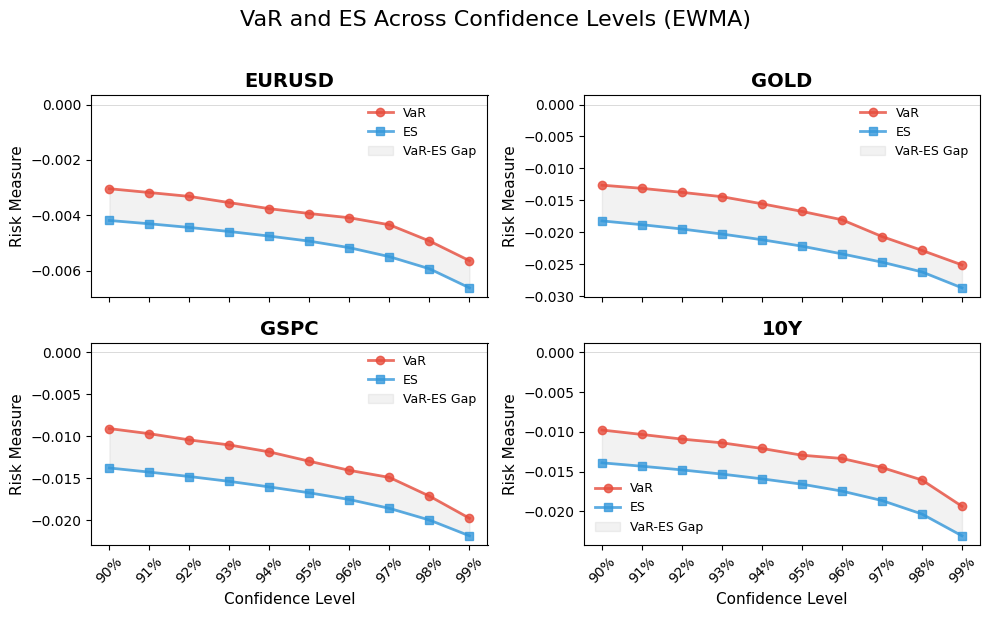

In [50]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get unique assets
assets = df_ewma_results['Asset'].unique()
n_assets = len(assets)

# If you have more than 4 assets, take only the first 4
if n_assets > 4:
    assets = assets[:4]
    n_assets = 4

# Create 2x2 subplots with shared x-axis
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
axes = axes.flatten()

# Color palette for better visualization
colors = ['#E74C3C', '#3498DB']  # Red for VaR, Blue for ES

for idx, asset in enumerate(assets):
    ax = axes[idx]

    # Filter data for this asset and sort by confidence level
    asset_data = df_ewma_results[df_ewma_results['Asset'] == asset].copy()

    # Convert confidence level to numeric for proper sorting and plotting
    asset_data['Confidence_Numeric'] = asset_data['Confidence Level'].str.rstrip('%').astype(float)
    asset_data = asset_data.sort_values('Confidence_Numeric')

    # Get x-axis values
    conf_levels = asset_data['Confidence_Numeric'].values
    conf_labels = asset_data['Confidence Level'].values

    # Plot VaR and ES
    ax.plot(conf_levels, asset_data['VaR'],
            marker='o', markersize=6, label='VaR',
            linewidth=2, color=colors[0], alpha=0.8)
    ax.plot(conf_levels, asset_data['ES'],
            marker='s', markersize=6, label='ES',
            linewidth=2, color=colors[1], alpha=0.8)

    # Fill between lines (VaR-ES gap)
    ax.fill_between(conf_levels,
                    asset_data['VaR'],
                    asset_data['ES'],
                    color='gray', alpha=0.1,
                    label='VaR-ES Gap')

    # Customize each subplot
    ax.set_title(f'{asset}', fontsize=14, fontweight='bold')
    # Only set xlabel for bottom row to avoid redundancy with shared x-axis
    if idx >= n_assets - 2 or n_assets <= 2: # For 2x2 grid, idx 2 and 3 are bottom row
        ax.set_xlabel('Confidence Level', fontsize=11)
    else:
        ax.set_xlabel('') # Clear xlabel for top row
    ax.set_ylabel('Risk Measure', fontsize=11)
    ax.set_xticks(conf_levels)
    ax.set_xticklabels(conf_labels, rotation=45 if len(conf_levels) > 5 else 0, fontsize=10)

    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.2, linewidth=0.5)

    # Add grid (if desired - set to False if you prefer no grid)
    ax.grid(False)

    # Add legend to each subplot
    ax.legend(fontsize=9, loc='best', frameon = False)

# Remove empty subplots if we have less than 4 assets
for idx in range(n_assets, 4):
    axes[idx].set_visible(False)

# Add overall title
plt.suptitle('VaR and ES Across Confidence Levels (EWMA)', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

### GARCH (1, 1) VaR

In [51]:
def calc_garch_var_es(df_returns, confidence_level):
  import numpy as np
  import pandas as pd
  from arch import arch_model

  if isinstance(df_returns, np.ndarray):
    returns = pd.Series(df_returns)
  else:
    returns = df_returns.copy()

  # Fit Garch(1,1) model for the sample
  model = arch_model(returns, vol='Garch', p=1, q=1, dist = 'normal')
  garch_result = model.fit(disp='off', show_warning = False)

  # Getting Standardized residuals
  standardized_residuals = garch_result.resid / garch_result.conditional_volatility
  standardized_residuals = standardized_residuals.dropna()

  # Forecast next period vol
  forecast = garch_result.forecast(horizon=1, reindex = False)
  current_vol = np.sqrt(forecast.variance.values[-1, 0])

  # Sort and calculate VaR and ES
  sorted_residuals = np.sort(standardized_residuals)
  var_idx = int(np.floor((1 - confidence_level) * len(sorted_residuals)))
  var_cutoff = sorted_residuals[var_idx]
  VaR = var_cutoff * current_vol

  losses_beyond_var = sorted_residuals[sorted_residuals <= var_cutoff]
  ES = np.mean(losses_beyond_var) * current_vol

  return VaR, ES


# Main calculation following your exact workflow pattern
confidence_levels = np.arange(0.90, 1.00, 0.01)
results = []

for confidence in confidence_levels:
    for asset in df_returns.columns:
        # Use the simple version for the loop
        var, es = calc_garch_var_es(df_returns[asset], confidence_level=confidence)
        results.append({
            'Asset': asset,
            'Confidence Level': f"{confidence*100:.0f}%",
            'VaR': var,
            'ES': es
        })

df_garch_fhs_results = pd.DataFrame(results)
df_garch_fhs_results.head()


/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.294e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base.py:694: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001146. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  self._check_scale(resids)
/usr/local/lib/python3.12/dist-packages/arch/univariate/base

,Asset,Confidence Level,VaR,ES
0,EURUSD,90%,-0.003835,-0.005768
1,GOLD,90%,-0.011125,-0.017281
2,GSPC,90%,-0.010245,-0.016617
3,10Y,90%,-0.014911,-0.022515
4,EURUSD,91%,-0.004077,-0.005972


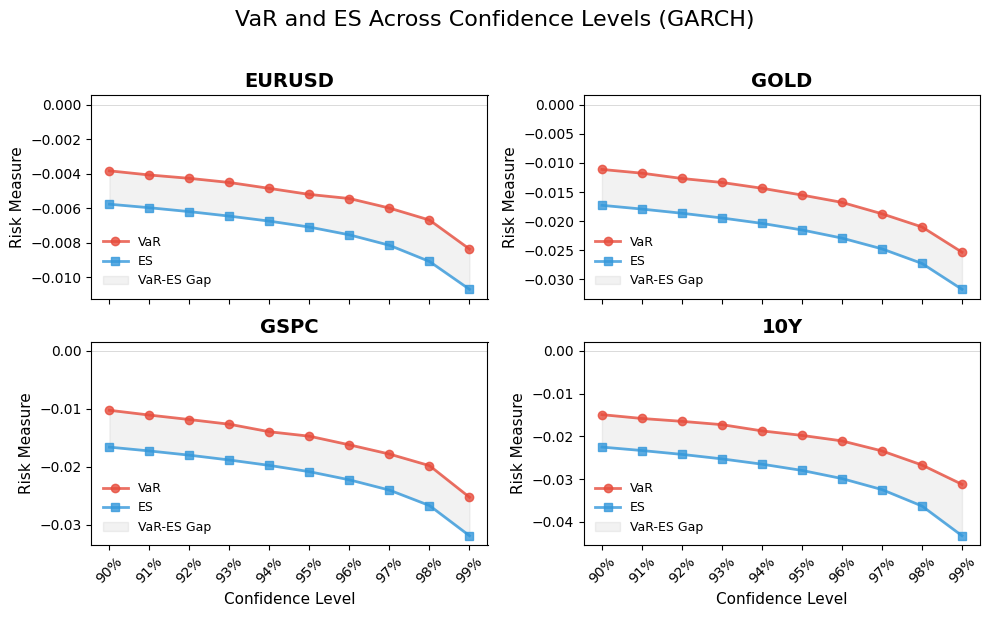

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get unique assets
assets = df_garch_fhs_results['Asset'].unique()
n_assets = len(assets)

# If you have more than 4 assets, take only the first 4
if n_assets > 4:
    assets = assets[:4]
    n_assets = 4

# Create 2x2 subplots with shared x-axis
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
axes = axes.flatten()

# Color palette for better visualization
colors = ['#E74C3C', '#3498DB']  # Red for VaR, Blue for ES

for idx, asset in enumerate(assets):
    ax = axes[idx]

    # Filter data for this asset and sort by confidence level
    asset_data = df_garch_fhs_results[df_garch_fhs_results['Asset'] == asset].copy()

    # Convert confidence level to numeric for proper sorting and plotting
    asset_data['Confidence_Numeric'] = asset_data['Confidence Level'].str.rstrip('%').astype(float)
    asset_data = asset_data.sort_values('Confidence_Numeric')

    # Get x-axis values
    conf_levels = asset_data['Confidence_Numeric'].values
    conf_labels = asset_data['Confidence Level'].values

    # Plot VaR and ES
    ax.plot(conf_levels, asset_data['VaR'],
            marker='o', markersize=6, label='VaR',
            linewidth=2, color=colors[0], alpha=0.8)
    ax.plot(conf_levels, asset_data['ES'],
            marker='s', markersize=6, label='ES',
            linewidth=2, color=colors[1], alpha=0.8)

    # Fill between lines (VaR-ES gap)
    ax.fill_between(conf_levels,
                    asset_data['VaR'],
                    asset_data['ES'],
                    color='gray', alpha=0.1,
                    label='VaR-ES Gap')

    # Customize each subplot
    ax.set_title(f'{asset}', fontsize=14, fontweight='bold')
    # Only set xlabel for bottom row to avoid redundancy with shared x-axis
    if idx >= n_assets - 2 or n_assets <= 2: # For 2x2 grid, idx 2 and 3 are bottom row
        ax.set_xlabel('Confidence Level', fontsize=11)
    else:
        ax.set_xlabel('') # Clear xlabel for top row
    ax.set_ylabel('Risk Measure', fontsize=11)
    ax.set_xticks(conf_levels)
    ax.set_xticklabels(conf_labels, rotation=45 if len(conf_levels) > 5 else 0, fontsize=10)

    # Add horizontal line at y=0
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.2, linewidth=0.5)

    # Add grid (if desired - set to False if you prefer no grid)
    ax.grid(False)

    # Add legend to each subplot
    ax.legend(fontsize=9, loc='best', frameon = False)

# Remove empty subplots if we have less than 4 assets
for idx in range(n_assets, 4):
    axes[idx].set_visible(False)

# Add overall title
plt.suptitle('VaR and ES Across Confidence Levels (GARCH)', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

## Monte Carlo VaR

### Normal Distribution

### Student t-Distribution